# Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
import joblib


# Load data

In [3]:
data = pd.read_csv("train.csv")
data.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


# Data Overview

In [4]:
data.info()
data.describe()
print("Null count:\n", data.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

# Feature Selection

In [5]:
numeric_features = ['GrLivArea', 'TotalBsmtSF', '1stFlrSF', 'FullBath', 
                    'GarageArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea']
categorical_features = ['OverallQual', 'GarageCars']
target = 'SalePrice'

X = data[numeric_features + categorical_features]
y = data[target]


# EDA

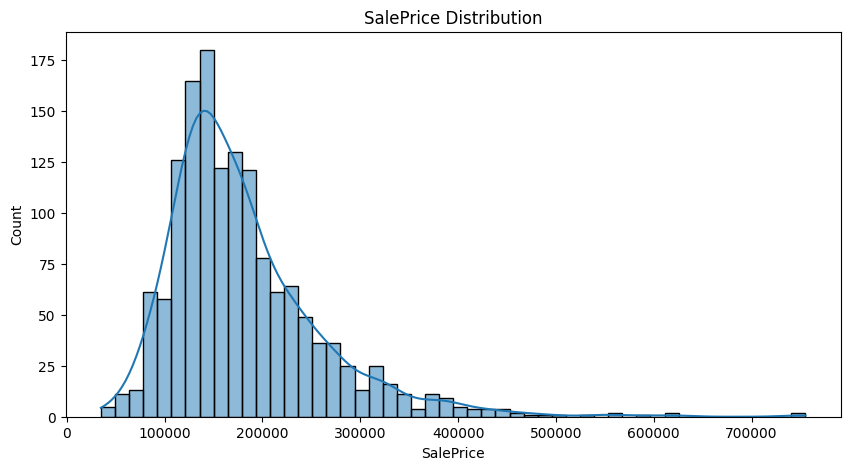

In [6]:
# Sale Distribution
plt.figure(figsize=(10,5))
sns.histplot(y, kde=True, bins=50)
plt.title("SalePrice Distribution")
plt.show()


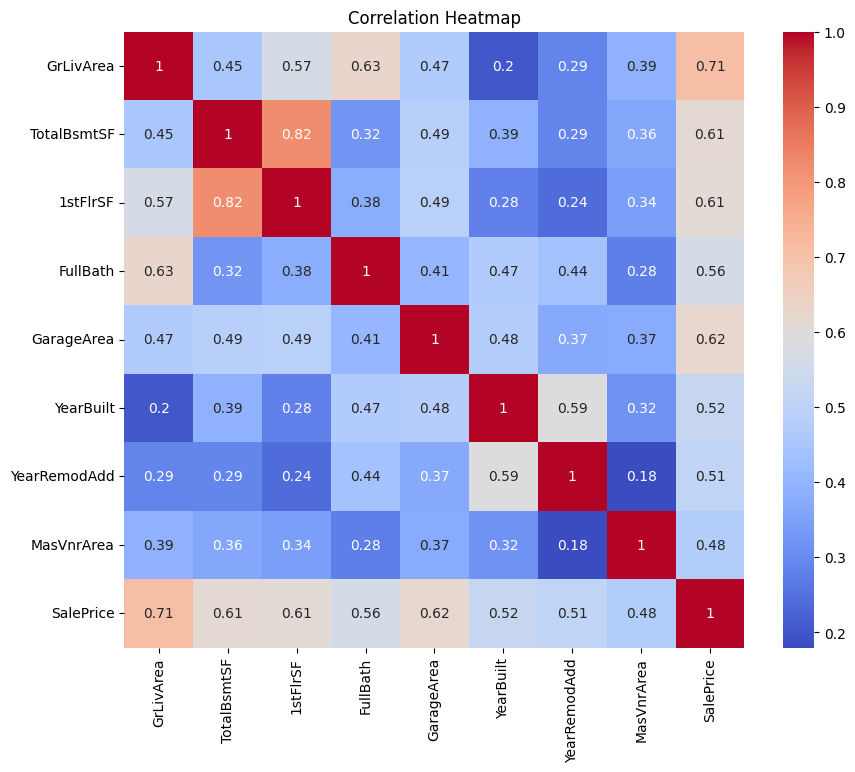

In [7]:
# Correlation Heatmap
plt.figure(figsize=(10,8))
sns.heatmap(data[numeric_features + [target]].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()


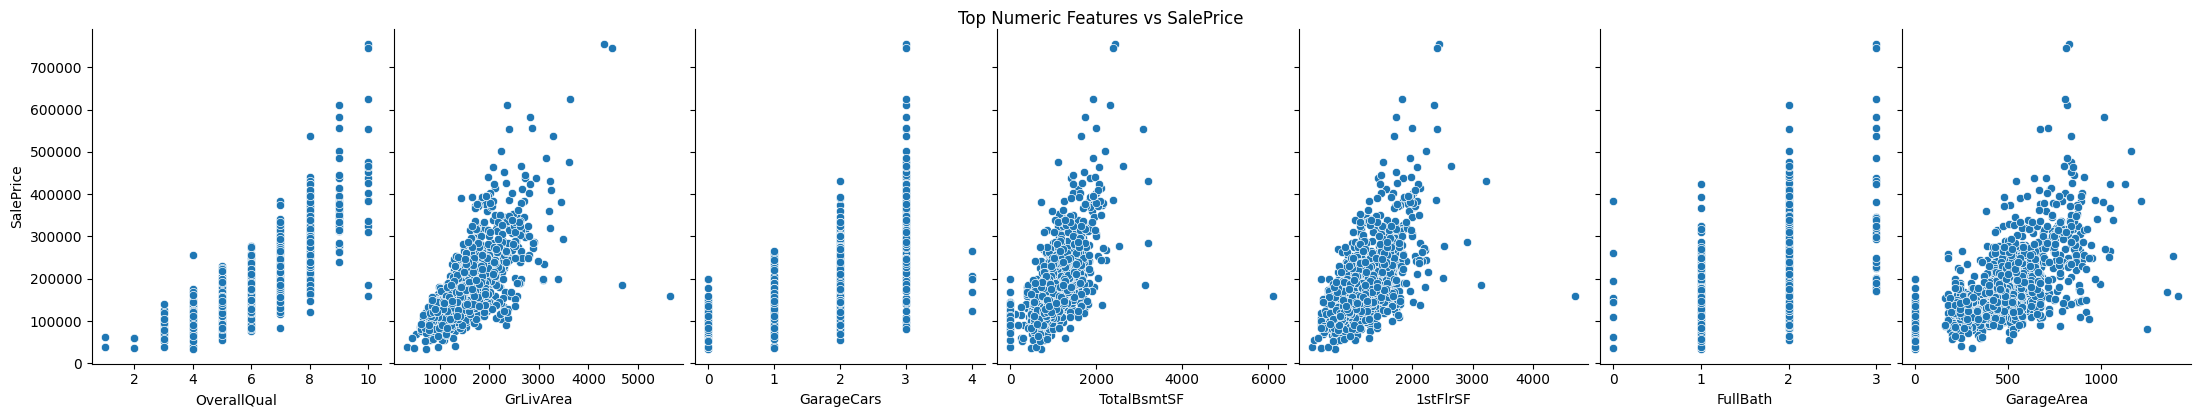

In [8]:
# Pairplot of top numeric features
top_features = ['OverallQual','GrLivArea','GarageCars','TotalBsmtSF','1stFlrSF','FullBath','GarageArea']
sns.pairplot(data, x_vars=top_features, y_vars='SalePrice', height=4, aspect=0.8, kind='scatter')
plt.suptitle("Top Numeric Features vs SalePrice", y=1.02)
plt.show()


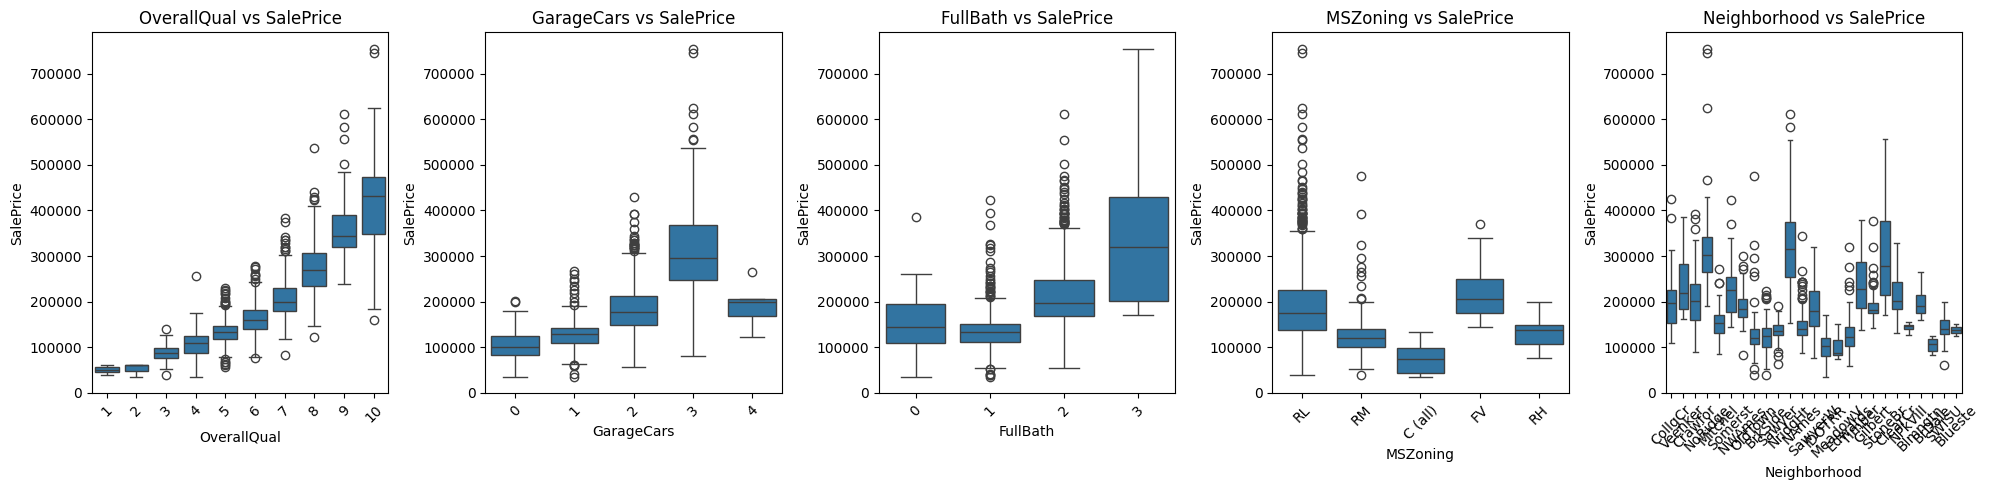

In [9]:
# Boxplots for categorical features
categorical_features_viz = ['OverallQual','GarageCars','FullBath','MSZoning','Neighborhood']
plt.figure(figsize=(20,5))
for i, col in enumerate(categorical_features_viz):
    plt.subplot(1, len(categorical_features_viz), i+1)
    sns.boxplot(x=col, y='SalePrice', data=data)
    plt.xticks(rotation=45)
    plt.title(f"{col} vs SalePrice")
plt.tight_layout()
plt.show()


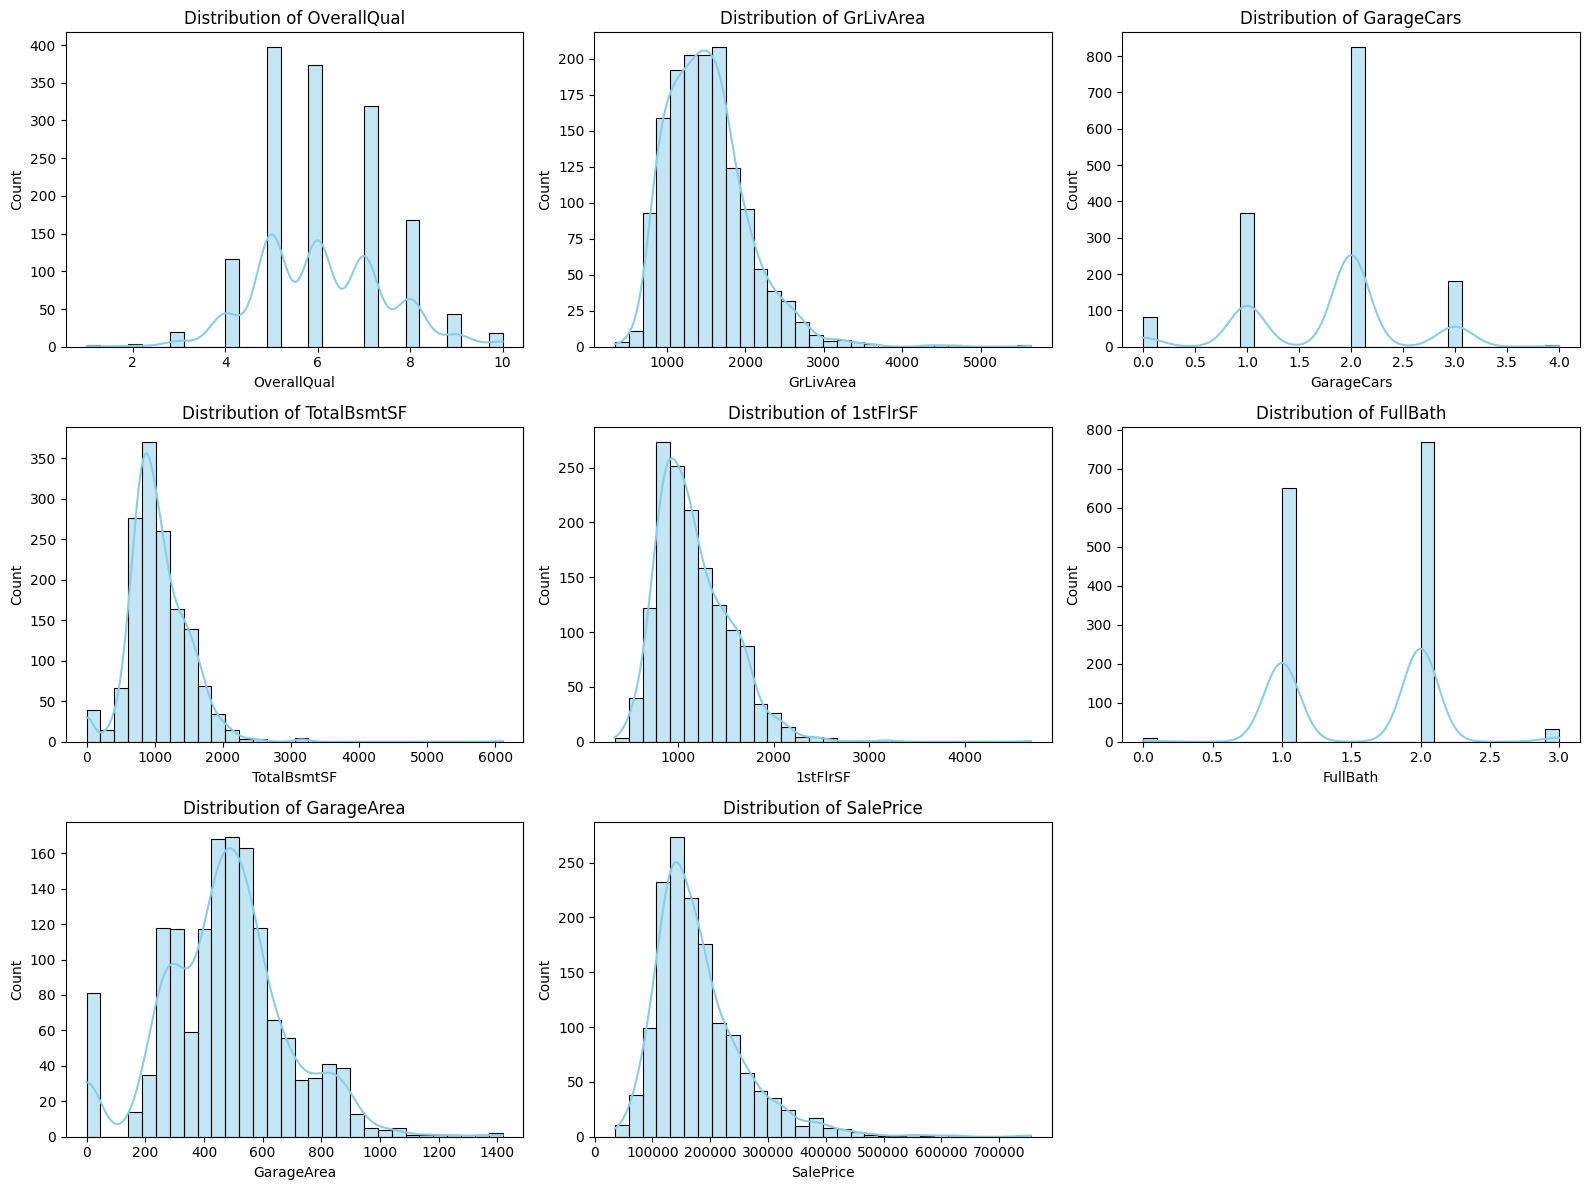

In [10]:
# Distribution Plots for Numeric Features
plt.figure(figsize=(16,12))
for i, col in enumerate(top_features + ['SalePrice']):
    plt.subplot(3,3,i+1)
    sns.histplot(data[col], kde=True, bins=30, color='skyblue')
    plt.title(f"Distribution of {col}")
plt.tight_layout()
plt.show()


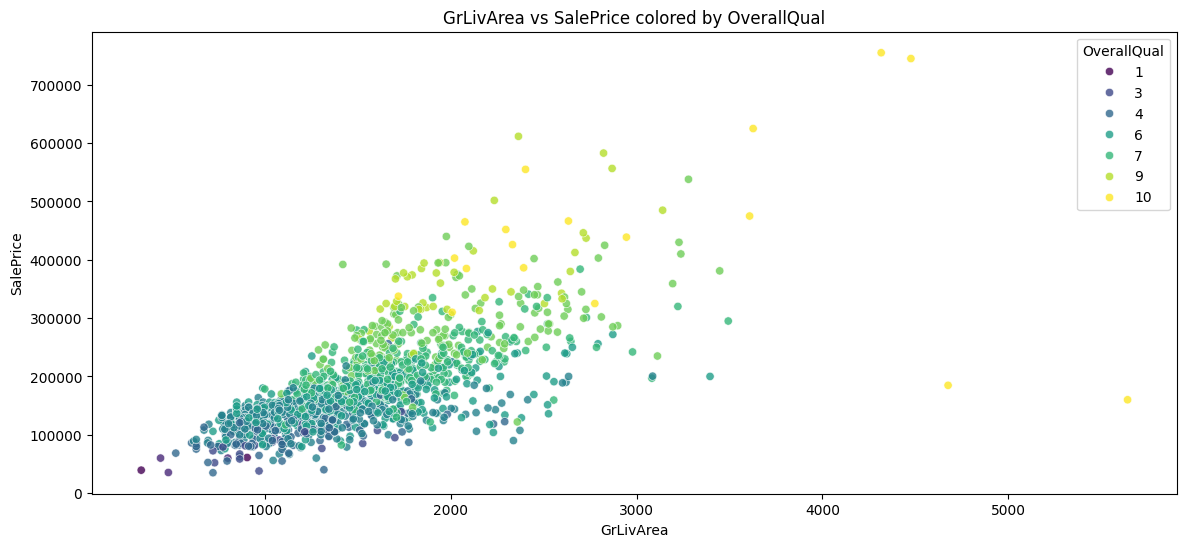

In [11]:
# Scatter Plot for Key Relationship
plt.figure(figsize=(14,6))
sns.scatterplot(x='GrLivArea', y='SalePrice', data=data, hue='OverallQual', palette='viridis', alpha=0.8)
plt.title("GrLivArea vs SalePrice colored by OverallQual")
plt.show()


In [12]:
# Fill numeric missing values with median
X[numeric_features] = X[numeric_features].fillna(X[numeric_features].median())

# Fill categorical missing values with mode
X[categorical_features] = X[categorical_features].fillna(X[categorical_features].mode().iloc[0])


C:\Users\VICTUS\AppData\Local\Temp\ipykernel_7648\4029121156.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[numeric_features] = X[numeric_features].fillna(X[numeric_features].median())
C:\Users\VICTUS\AppData\Local\Temp\ipykernel_7648\4029121156.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[categorical_features] = X[categorical_features].fillna(X[categorical_features].mode().iloc[0])


# Train/Test split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


# Preprocessing

In [14]:
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)


# Model Pipeline

In [15]:
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(
        n_estimators=1000,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    ))
])


In [16]:
# Train Model
model.fit(X_train, y_train)


,steps,"[('preprocessor', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [17]:
# Evaluate Model
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("📊 Model Evaluation Metrics:")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.4f}")


📊 Model Evaluation Metrics:
MAE: 20639.69
RMSE: 33077.03
R² Score: 0.8574


# Predict Vs Actual Plot

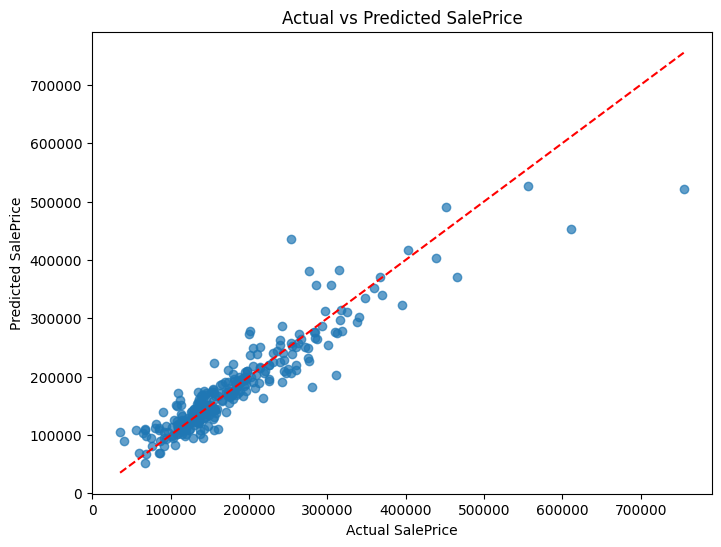

In [18]:
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual SalePrice")
plt.ylabel("Predicted SalePrice")
plt.title("Actual vs Predicted SalePrice")
plt.show()


In [19]:
# Save the model
joblib.dump(model, "house_price_xgb_model.pkl")
print("✅ Model saved as house_price_xgb_model.pkl")


✅ Model saved as house_price_xgb_model.pkl


In [20]:
# Features you are interested in
features = [
    'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF',
    '1stFlrSF', 'FullBath', 'GarageArea', 'YearBuilt',
    'YearRemodAdd', 'MasVnrArea'
]

# Subset your dataset to only these features
df_features = data[features]

df_features_price = data[features + ['SalePrice']]
print("👀 Preview of features with SalePrice:")
df_features_price.tail()



👀 Preview of features with SalePrice:


,OverallQual,GrLivArea,GarageCars,TotalBsmtSF,1stFlrSF,FullBath,GarageArea,YearBuilt,YearRemodAdd,MasVnrArea,SalePrice
1455,6,1647,2,953,953,2,460,1999,2000,0.0,175000
1456,6,2073,2,1542,2073,2,500,1978,1988,119.0,210000
1457,7,2340,1,1152,1188,2,252,1941,2006,0.0,266500
1458,5,1078,1,1078,1078,1,240,1950,1996,0.0,142125
1459,5,1256,1,1256,1256,1,276,1965,1965,0.0,147500


In [21]:
# Load and predict with the saved model
sample_input = pd.DataFrame([{
    'OverallQual': 7,
    'GrLivArea': 1710,
    'GarageCars': 2,
    'TotalBsmtSF': 856,
    '1stFlrSF': 856,
    'FullBath': 2,
    'GarageArea': 548,
    'YearBuilt': 2003,
    'YearRemodAdd': 2003,
    'MasVnrArea': 196
}])

loaded_model = joblib.load("house_price_xgb_model.pkl")
predicted_price = loaded_model.predict(sample_input)[0]

print(f"🏡 Predicted House Price: ${predicted_price:,.2f}")


🏡 Predicted House Price: $207,127.72


In [22]:
# Load and predict with the saved model
sample_input = pd.DataFrame([{
    'OverallQual': 6,
    'GrLivArea': 1262,
    'GarageCars': 2,
    'TotalBsmtSF': 1262,
    '1stFlrSF': 1262,
    'FullBath': 2,
    'GarageArea': 460,
    'YearBuilt': 1976,
    'YearRemodAdd': 1976,
    'MasVnrArea': 0
}])

loaded_model = joblib.load("house_price_xgb_model.pkl")
predicted_price = loaded_model.predict(sample_input)[0]

print(f"🏡 Predicted House Price: ${predicted_price:,.2f}")

🏡 Predicted House Price: $176,172.34


In [23]:
# Predict SalePrice on training data
train_predicted_prices = loaded_model.predict(X_train)
# Create a DataFrame to compare
train_comparison = X_train.copy()
train_comparison['Actual_SalePrice'] = y_train
train_comparison['Predicted_SalePrice'] = train_predicted_prices

# Preview
train_comparison.head(10)


,GrLivArea,TotalBsmtSF,1stFlrSF,FullBath,GarageArea,YearBuilt,YearRemodAdd,MasVnrArea,OverallQual,GarageCars,Actual_SalePrice,Predicted_SalePrice
254,1314,1314,1314,1,294,1957,1957,0.0,5,1,145000,144296.046875
1066,1571,799,799,2,380,1993,1994,0.0,6,2,178000,175851.968750
638,796,796,796,1,0,1910,1950,0.0,5,0,85000,83378.578125
799,1768,731,981,1,240,1937,1950,252.0,5,1,175000,171510.531250
380,1691,1026,1026,2,308,1924,1950,0.0,5,1,127000,127963.695312
303,894,894,894,1,552,1972,1972,0.0,5,2,149900,143445.125000
86,1560,684,684,2,400,2005,2005,0.0,6,2,174000,175338.328125
1385,1154,796,796,1,240,1922,2007,0.0,4,1,125500,123838.296875
265,1422,1422,1422,2,576,1981,1981,210.0,6,2,175500,172643.203125
793,1496,1496,1496,2,474,2007,2007,140.0,8,2,225000,228149.843750


In [24]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

mae_train = mean_absolute_error(y_train, train_predicted_prices)
rmse_train = np.sqrt(mean_squared_error(y_train, train_predicted_prices))
r2_train = r2_score(y_train, train_predicted_prices)

print("📊 Model Performance on Training Data:")
print(f"MAE: {mae_train:.2f}")
print(f"RMSE: {rmse_train:.2f}")
print(f"R² Score: {r2_train*100:.4f}")


📊 Model Performance on Training Data:
MAE: 2125.32
RMSE: 2873.26
R² Score: 99.8616


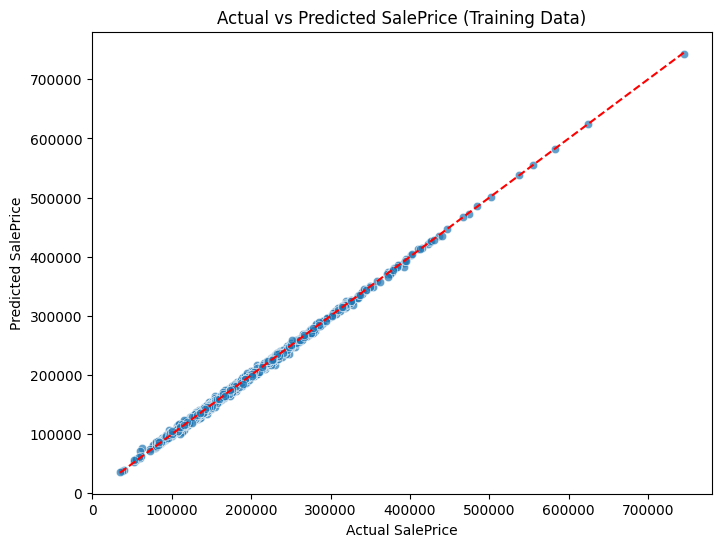

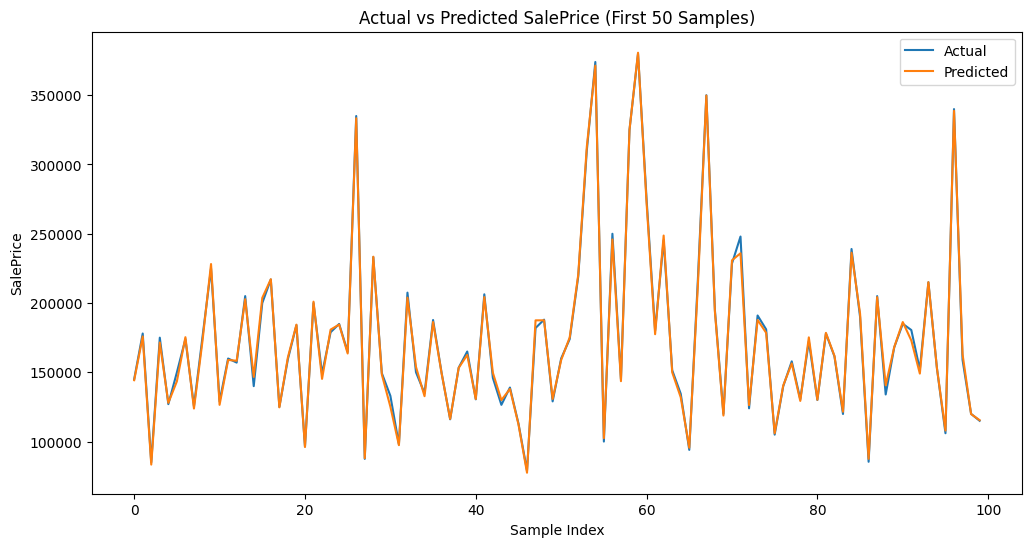

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a DataFrame with actual and predicted values
train_results = X_train.copy()
train_results['Actual_SalePrice'] = y_train
train_results['Predicted_SalePrice'] = train_predicted_prices

# Scatter plot: Actual vs Predicted
plt.figure(figsize=(8,6))
sns.scatterplot(x='Actual_SalePrice', y='Predicted_SalePrice', data=train_results, alpha=0.7)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--')  # reference line
plt.xlabel("Actual SalePrice")
plt.ylabel("Predicted SalePrice")
plt.title("Actual vs Predicted SalePrice (Training Data)")
plt.show()

# Optional: Line plot for first 50 entries to see alignment
plt.figure(figsize=(12,6))
plt.plot(train_results['Actual_SalePrice'].values[:100], label='Actual', marker='')
plt.plot(train_results['Predicted_SalePrice'].values[:100], label='Predicted', marker='')
plt.xlabel("Sample Index")
plt.ylabel("SalePrice")
plt.title("Actual vs Predicted SalePrice (First 50 Samples)")
plt.legend()
plt.show()


In [26]:
import pandas as pd

# Load test dataset
test_data = pd.read_csv("test.csv")

# Preview the first few rows
print("👀 Test dataset preview:")
test_data.head()


👀 Test dataset preview:


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [27]:
# Features to extract
features = [
    'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF',
    '1stFlrSF', 'FullBath', 'GarageArea', 'YearBuilt',
    'YearRemodAdd', 'MasVnrArea'
]

# Subset the test dataset
test_features = test_data[features]

# Preview the first 5 rows
print("👀 Selected features from test dataset:")
test_features.head()


👀 Selected features from test dataset:


,OverallQual,GrLivArea,GarageCars,TotalBsmtSF,1stFlrSF,FullBath,GarageArea,YearBuilt,YearRemodAdd,MasVnrArea
0,5,896,1.0,882.0,896,1,730.0,1961,1961,0.0
1,6,1329,1.0,1329.0,1329,1,312.0,1958,1958,108.0
2,5,1629,2.0,928.0,928,2,482.0,1997,1998,0.0
3,6,1604,2.0,926.0,926,2,470.0,1998,1998,20.0
4,8,1280,2.0,1280.0,1280,2,506.0,1992,1992,0.0


In [28]:
import joblib

# Load the trained model
loaded_model = joblib.load("house_price_xgb_model.pkl")

# Predict SalePrice for test dataset
predicted_prices = loaded_model.predict(test_features)

# Combine predictions with test features (optional)
test_results = test_features.copy()
test_results['Predicted_SalePrice'] = predicted_prices

# Preview results
test_results.head(3)


,OverallQual,GrLivArea,GarageCars,TotalBsmtSF,1stFlrSF,FullBath,GarageArea,YearBuilt,YearRemodAdd,MasVnrArea,Predicted_SalePrice
0,5,896,1.0,882.0,896,1,730.0,1961,1961,0.0,124435.875000
1,6,1329,1.0,1329.0,1329,1,312.0,1958,1958,108.0,156362.203125
2,5,1629,2.0,928.0,928,2,482.0,1997,1998,0.0,176949.890625


In [29]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Predict on test set
test_predicted_prices = loaded_model.predict(X_test)

# Calculate metrics
mae_test = mean_absolute_error(y_test, test_predicted_prices)
rmse_test = np.sqrt(mean_squared_error(y_test, test_predicted_prices))
r2_test = r2_score(y_test, test_predicted_prices)

print("📊 Model Performance on Test Data:")
print(f"MAE: {mae_test:.2f}")
print(f"RMSE: {rmse_test:.2f}")
print(f"R² Score: {r2_test*100:.4f}")


📊 Model Performance on Test Data:
MAE: 20639.69
RMSE: 33077.03
R² Score: 85.7361


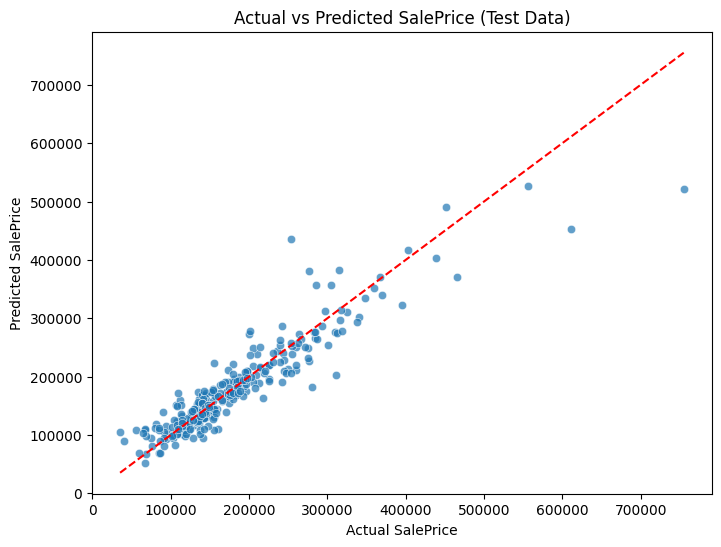

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plot for test data
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=test_predicted_prices, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # perfect prediction line
plt.xlabel("Actual SalePrice")
plt.ylabel("Predicted SalePrice")
plt.title("Actual vs Predicted SalePrice (Test Data)")
plt.show()
